# <center> <img src="../../labs/img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
### <center> **Big Data** </center>
---
### <center> **Spring 2025** </center>
---
**Mid-term exam**

**Date**: 3/12/2025

**Student Name**: Francisco Aarón Ortega Anguiano

**Professor**: Pablo Camarillo Ramirez

In [79]:
import findspark
findspark.init()

In [80]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("SparkSQL-Exam-1-Aaron-Ortega") \
    .master("spark://93a435690e65:7077") \
    .config("spark.ui.port","4040") \
    .getOrCreate()
sc = spark.sparkContext

### Read the Data (10 points):
- Load the `sales.csv` and `products.csv` files into PySpark DataFrames. **You need to use your team's spark_utils implementation to produce the schema**.

In [81]:
import importlib
import team_ParDeDos.spark_utils

importlib.reload(team_ParDeDos.spark_utils)

columns_info = [
  ("product_id", "integer"),
  ("product_name", "string"),
  ("category", "string"),
  ("price", "double")
]

schema = team_ParDeDos.spark_utils.SparkUtils.generate_schema(columns_info)

# Create DataFrame
products_df = spark \
                .read \
                .schema(schema) \
                .option("header", "true") \
                .csv("/home/jovyan/notebooks/data/mid_exam/products.csv")

In [82]:
columns_info = [
  ("transaction_id", "integer"),
  ("product_id", "integer"),
  ("customer_id", "integer"),
  ("sale_amount", "double"),
  ("sale_date", "date")
]

schema = team_ParDeDos.spark_utils.SparkUtils.generate_schema(columns_info)

sales_df = spark.read \
                .schema(schema) \
                .option("header", "true") \
                .csv("/home/jovyan/notebooks/data/mid_exam/sales.csv")

### Join Operations (20 points):
- Join the `sales` DataFrame with the `products` DataFrame on `product_id` to enrich the sales data with product details.

In [83]:
join_result = sales_df.join(products_df,
														sales_df["product_id"] == products_df["product_id"],
														"left")

### Group and Aggregate (10 points):
- Calculate the total sales amount (`sale_amount`) for each product category (`category`).

In [84]:
from pyspark.sql.functions import sum

total_sales_df = join_result.groupBy("category").agg(
	sum("sale_amount").alias("sum_sales")
)

### Transformations (Using `when()`) (20 points):
- Add a new column `sale_type` to the enriched sales DataFrame:
	- If `sale_amount` is greater than or equal to 50, set `sale_type` to "High".
	- Otherwise, set `sale_type` to "Low".

In [85]:
from pyspark.sql.functions import when

transformed_df = join_result.withColumn('sale_type', when(join_result['sale_amount'] >= 50, "High").otherwise("Low"))

### Filter (10 points):
- Filter the enriched sales DataFrame to include only rows where the `category` is "Electronics".

In [86]:
from pyspark.sql.functions import col

filtered_df = transformed_df.filter(col("category") == "Electronics")

### Select (10 points):
- Select only the `product_name`, `sale_amount`, and `sale_type` columns from the filtered DataFrame.

In [87]:
selected_df = filtered_df.select(col("product_name"),col("sale_amount"),col("sale_type"))

selected_df.show(5)
selected_df.count()

+------------+-----------+---------+
|product_name|sale_amount|sale_type|
+------------+-----------+---------+
| Product 175|     232.46|     High|
| Product 177|      460.4|     High|
| Product 139|     575.25|     High|
| Product 100|     513.06|     High|
| Product 115|      60.44|     High|
+------------+-----------+---------+
only showing top 5 rows



612

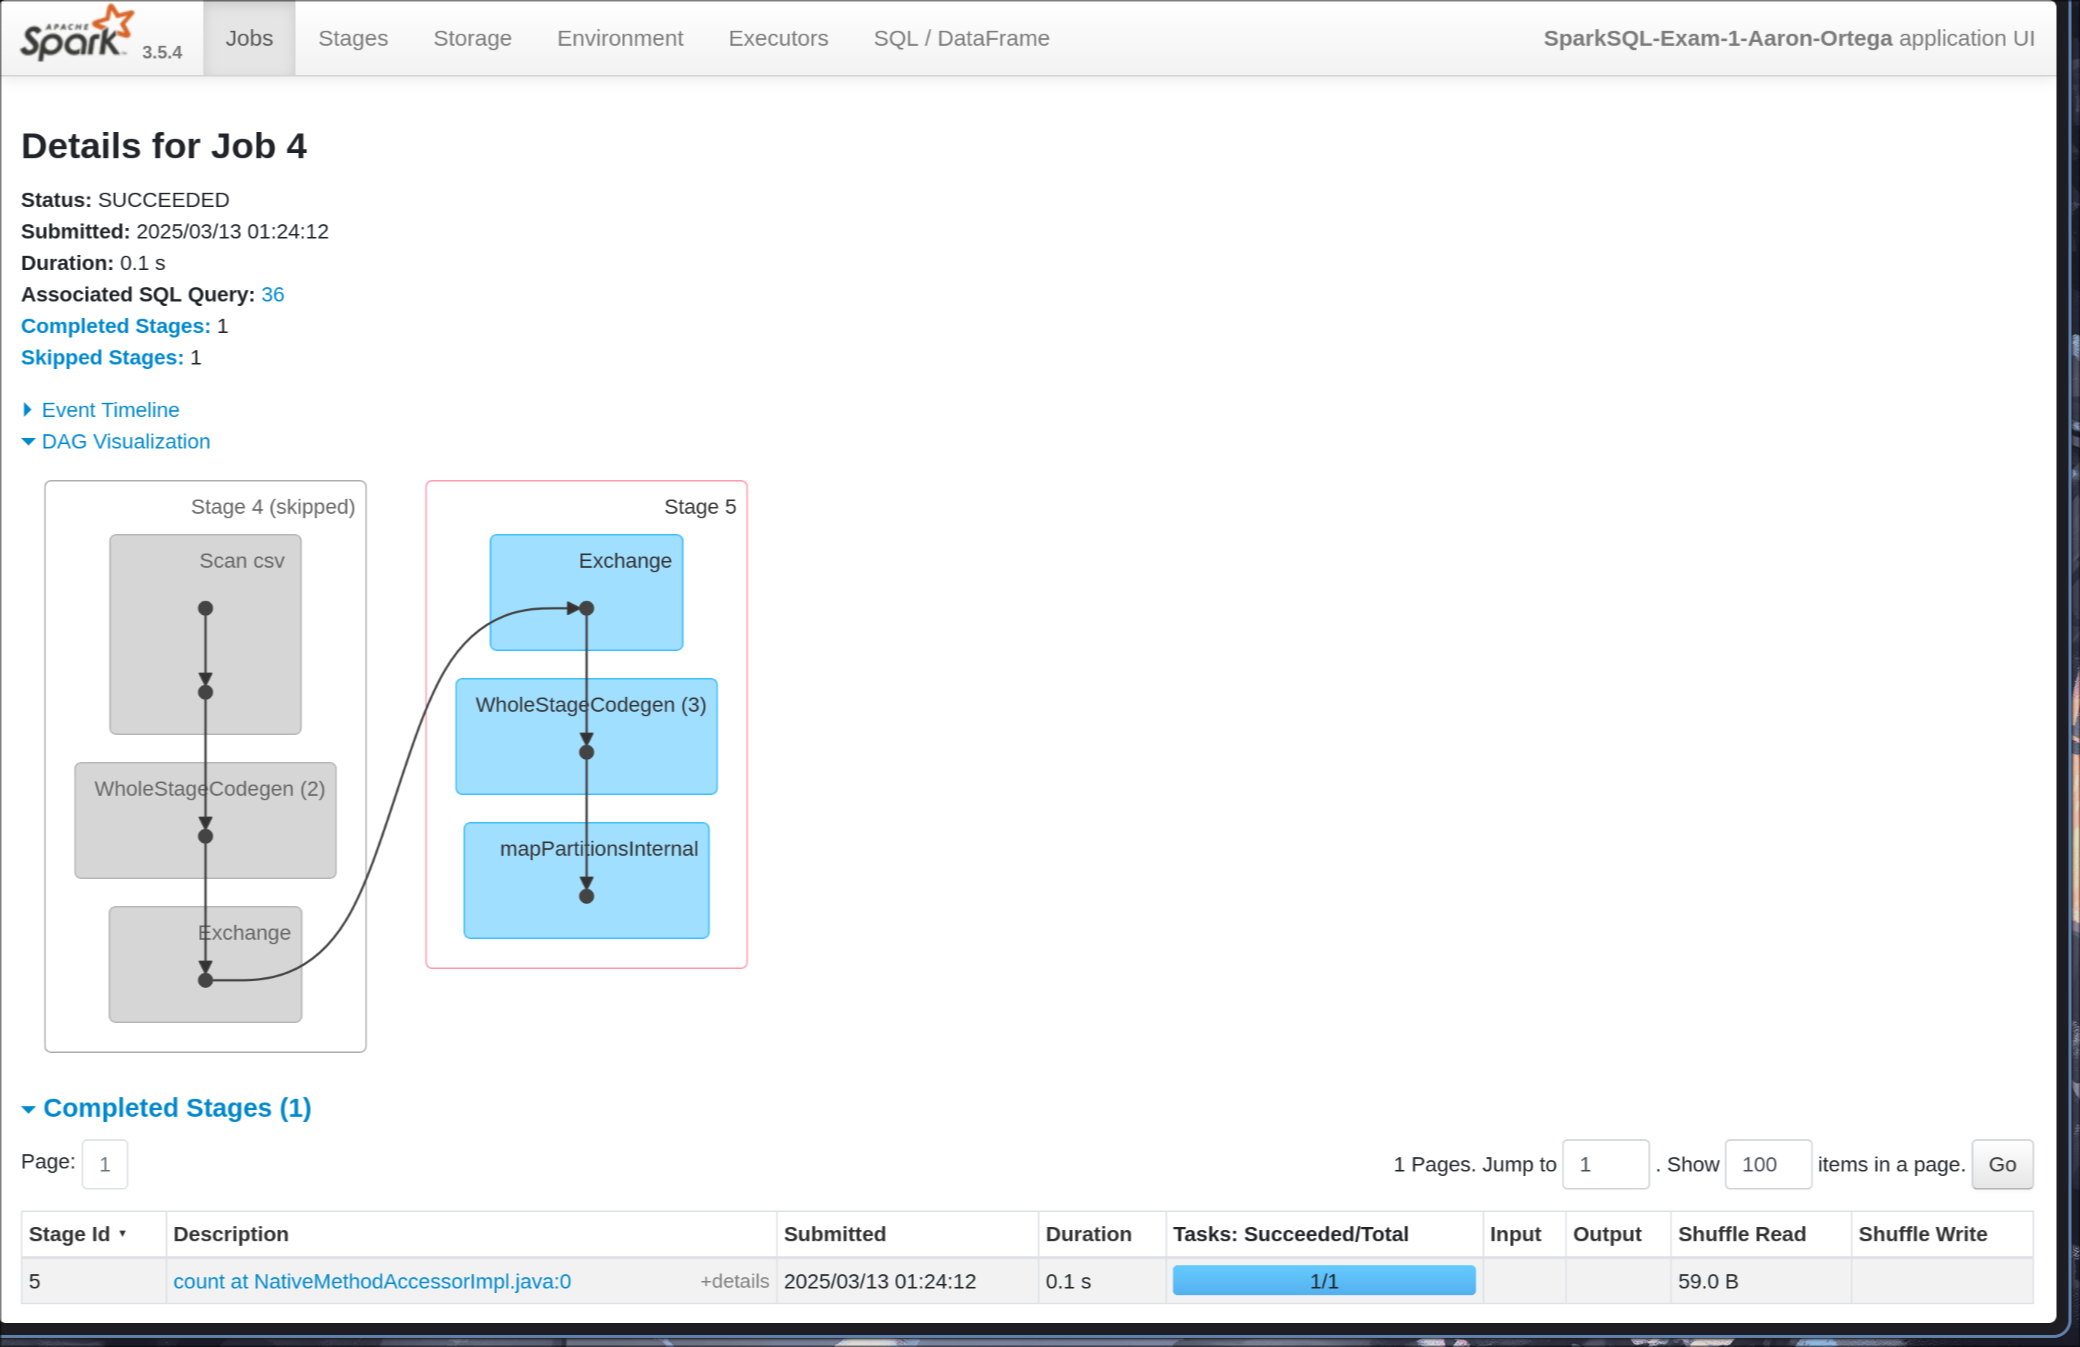

In [88]:
sc.stop()